### 0.导入函数库

In [1]:
%matplotlib inline
from obspy.core import read
from obspy.core import UTCDateTime
from obspy import read_inventory
from obspy.imaging.cm import pqlx
from obspy.signal.invsim import cosine_taper 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

### 1.窗函数和平滑窗
****
1. 有时，我们有一个非常长的信号，但只需要其中的一小部分，例如，在一个包含整天记录的文件中记录地震。然后，为了加快处理速度并使绘图更清晰，我们需要截取我们感兴趣的部分。这也称为对信号进行窗处理，因为它类似于在频域中对数据应用方框/窗函数。<br>

2. 在数字信号处理中，当将数据转换为频域时，产生不连续现象的原因主要有两个方面：
信号的截断：在数字信号处理中，通常会对连续信号进行采样和量化，将其离散化为一系列的样本点。如果信号的采样长度不是周期性的，或者在处理过程中对信号进行了截断，即使起始时的样本幅度是连续的，最后的样本幅度也可能不与其相同。截断引入了额外的边界效应，导致频域上的不连续现象。
周期扩展：在进行频域转换时，通常会假设信号是周期性的，即重复出现的。然而，实际信号往往不是完美的周期信号。如果信号在时间轴上的周期性不完美，或者存在非整数倍关系的周期性，频域转换会产生不连续现象。这是因为频域转换对信号的周期性有一定的要求，不符合要求的信号会导致频域上的不连续性。
综上所述，数字信号处理中信号的截断和周期性不完美是导致在频域转换时产生不连续现象的主要原因。为了减少这种现象的影响，可以采用合适的窗函数（如汉宁窗、汉明窗等）来减少边界效应，并确保信号的周期性和连续性满足频域转换的要求。

3. 吉布斯现象（Gibbs Phenomenon）是信号处理和数学领域中的一个概念，描述的是当使用有限数量的正弦波或余弦波对一个连续信号进行傅里叶级数展开时，可能出现的一种特殊现象。具体来说，当信号在某些不连续点处的傅里叶级数展开收敛时，会出现局部的振荡和过冲现象。这种现象在信号处理领域中十分常见，尤其是在对信号进行滤波、重建或逼近时。
吉布斯现象的原因主要在于傅里叶级数展开中使用的正弦波和余弦波具有无穷的延续性，而实际信号可能在某些点上存在突变。因此，当用有限数量的正弦波和余弦波来逼近这些突变点时，会出现局部的振荡和过冲。
为了减轻吉布斯现象带来的影响，研究者们提出了一些方法，如使用窗函数（window function）进行加权处理，或采用其他基函数（如小波）进行信号分析和重建。这些方法可以在一定程度上降低吉布斯现象的影响，从而提高信号处理的准确性。
****
```
1) 实际数据通常不会以与开始时相同的样本幅度结束。最迟在切割数据时就会出现这种情况。当将数据转换为频域时，我们因此会产生一个不连续的现象，这会产生吉布斯效应。在之后对数据进行过滤时也会出现问题。因此，我们需要将最后一个样本幅度调整为与第一个样本相同的值，传统上为零。<br>
2) 这就是锥形所做的：逐渐将信号开头和结尾的几个样本减小到零。锥形是一种在时域中应用的窗口函数，即逐个样本地乘以数据。
锥形的百分比定义了信号开头和结尾受锥形影响的样本数。例如，当一个具有100个样本的信号被锥形10%时，第一个和最后一个10个样本的幅度逐渐减小，直到达到零。在中间，锥形值为1，因此根本不改变样本幅度。在中间，信号保持不变。<br>
3) 锥形的斜率变得更加平缓，更多的样本受到锥形的影响。这也意味着，我们正在“丢弃”部分信号，从而丢失信息。
应用锥形始终是在尽可能保留信息（低锥形百分比）和使幅度减小尽可能平缓（高锥形百分比）之间的平衡。如果减小幅度不够平缓，我们可能会在后面再次遇到问题，例如当我们想要过滤数据时。原因是过滤是在频域中完成的。粗糙的幅度减小到零类似于数据中的不连续，我们又回到了吉布斯现象。
4） 设置a多种初始信号，使用简单的cos函数作为平滑窗。在使用ObsPy处理实际数据时，可以选择多种平滑窗。应用的平滑窗百分比比所选窗口类型产生的影响要大得多。
```

Before Taper
amplitude of first sample point:   1.7
amplitude of last sample point:  -0.0
After Taper
amplitude of first sample point:   0.0
amplitude of last sample point:  -0.0


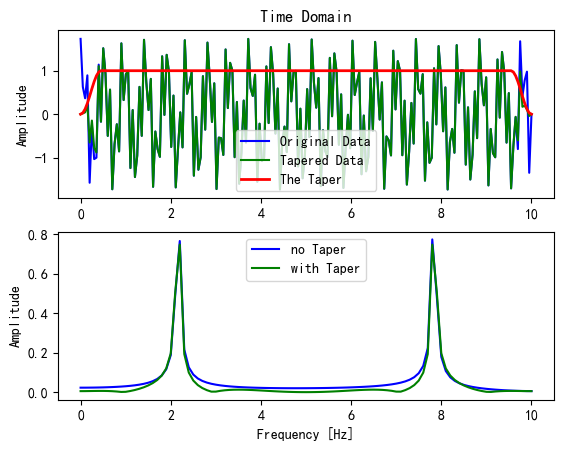

In [2]:
samp = 200                                # 采样点数量（初始值：200）
delta = 0.05                              # 采样间隔（初始值：0.05）
freq1 = 2.15                              # 产生信号的发生器频率（初始值：2.15）
freq2 = 7.8                               # 产生信号的发生器频率（初始值：7.8）
temp = np.linspace(0.0, samp*delta, samp) # 时间轴（单位：秒）

# 设置初始信号
# 生成频率为freq1赫兹的正弦波信号
# dat = np.sin(freq1 * 2.0 * np.pi * temp)
# 为正弦波的零点添加一个偏移量
dat = np.sin(freq1 * 2.0 * np.pi * temp + np.pi/3)
## 将频率为freq2赫兹的另一个正弦波添加到信号中
dat = dat + np.sin(freq2 * 2.0 * np.pi * temp + np.pi/3)
#noise_amplitude = 0.7
## 为信号添加噪声
#dat = dat + np.random.randn(len(dat)) * noise_amplitude 
# 确定数据的最大振幅（用于绘图）
maximum = max(dat)

print('Before Taper')
print('amplitude of first sample point:%6.1f' %dat[0])
print('amplitude of last sample point:%6.1f' %(dat[len(dat)-1]))

# 定义平滑窗
# 应用的锥度百分比[0. - 1.]（初始值：0.1）
taper_percentage = 0.1
# 定义锥度窗口。
taper = cosine_taper(samp,taper_percentage)
# 对信号进行锥度处理。
dat_taper = dat * taper

print('After Taper')
print('amplitude of first sample point:%6.1f' %dat_taper[0])
print('amplitude of last sample point:%6.1f' %(dat_taper[len(dat_taper)-1]))

# 将FFT数据转换为频域数据
Fdat = np.fft.rfft(dat, n=samp)
Fdat_taper = np.fft.rfft(dat_taper, n=samp)
# 用于绘图的频域x轴
xf = np.linspace(0.0, 1.0/(2.0*delta), int((samp/2)+1))

# 绘图
plt.subplot(211)
plt.title('Time Domain')
plt.plot(temp, dat, label="Original Data", color='b', linewidth=1.5)
plt.plot(temp, dat_taper, label="Tapered Data", color='g',linewidth=1.5)
plt.plot(temp, taper, label="The Taper", color='r', linewidth=2)
plt.legend(loc='lower center')
plt.ylabel('Amplitude')
plt.ylim(-(maximum+0.2),maximum+0.2)

plt.subplot(212)
plt.plot(xf, 2.0/samp * np.abs(Fdat), color='b',label="no Taper",linewidth=1.5)
plt.plot(xf, 2.0/samp * np.abs(Fdat_taper), label="with Taper", color='g',linewidth=1.5)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### 2.滤波器
****
在地震学中，滤波器用于校正仪器响应，避免混叠效应，将“期望的”频率与“非期望的”频率分离，识别谐波信号，模拟特定的记录仪器等。对于滤波器并没有明确的分类。粗略地说，我们可以区分线性与非线性、模拟（电路、电阻、导线）与数字（逻辑元件）以及连续与离散滤波器。在地震学中，我们通常避免使用非线性滤波器，因为它们的输出包含输入信号中没有的频率。模拟滤波器可以是连续或离散的，而数字滤波器总是离散的。离散滤波器可以分为无限冲激响应（IIR）滤波器和有限冲激响应（FIR）滤波器。IIR滤波器是递归和因果的，而FIR滤波器是非递归、因果或非因果的。一些滤波器有特定的名称，例如Butterworth、Chebyshev或Bessel滤波器，但它们也可以被包含在上述分类中。<br>
有4种主要类型的滤波器：低通滤波器、高通滤波器、带通滤波器和带阻滤波器。低通和高通滤波器只有一个截止频率，分别允许低于和高于该截止频率的频率通过滤波器。相比之下，带通和带阻滤波器具有两个截止频率，分别定义了一个频率带用于通过和阻止。在这里，我们想要看到这些滤波器在输入信号上的具体作用。
****
```
滤波器通过其频率响应函数来描述，该函数是输出信号的傅里叶变换除以输入信号的傅里叶变换。
注意，选择滤波器的阶数需要权衡滤波效果和计算复杂度之间的关系。较高的阶数可能会增加计算负担，并且可能不一定总是产生更好的滤波结果。因此，需要根据具体应用场景和要求进行选择。
```

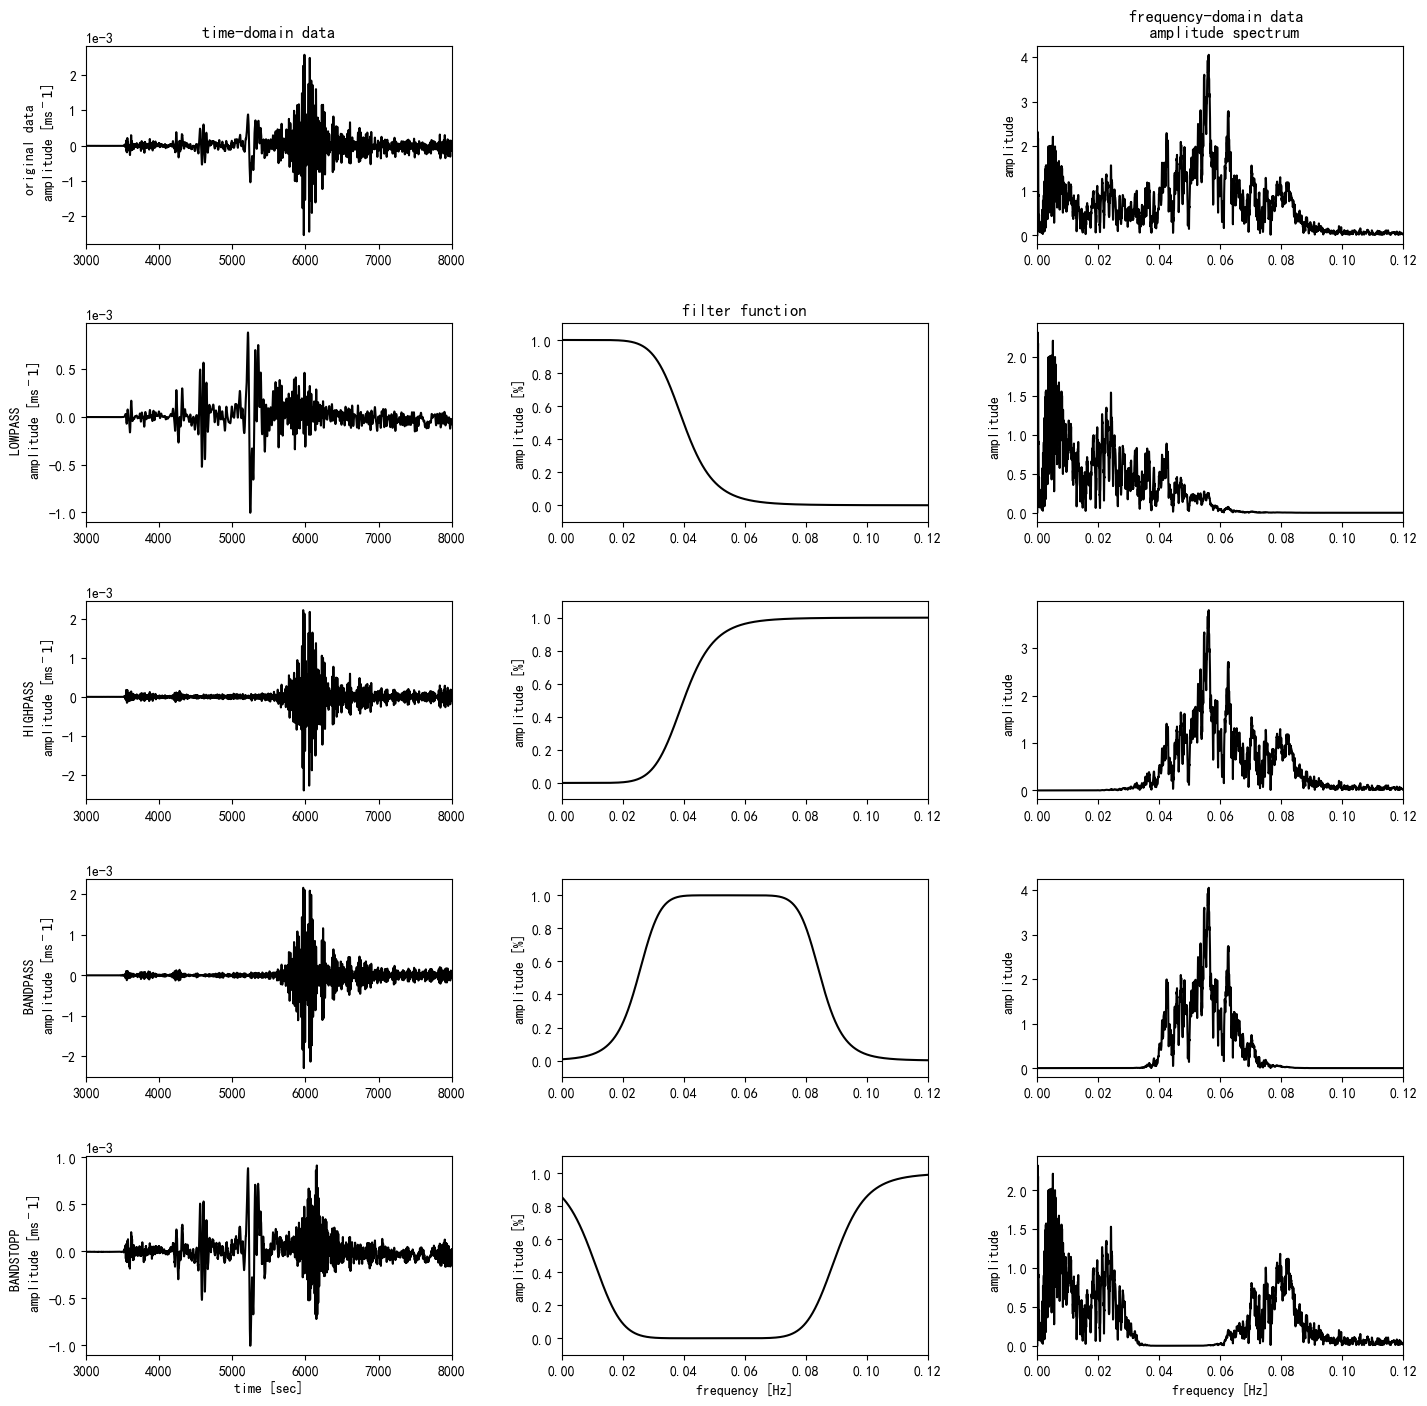

In [3]:
st = read("../data/spect_trace.mseed")
# 去仪器响应
inv = read_inventory("../data/GR.WET.xml")
st.remove_response(output="VEL", inventory=inv)
st.detrend('linear')
st.detrend('demean')

# 滤波器类型
npts = st[0].stats.npts                   # 样本数量
dt = st[0].stats.delta                    # 采样间隔
fNy = 1. / (2. * dt)                      # 奈奎斯频率
time = np.arange(0, npts) * dt            # 时间轴
freq = np.linspace(0, fNy, npts // 2 + 1) # 频率轴
corners = 4                               # 滤波器阶数
# 不同滤波器类型的几个滤波频率
f0 = 0.04
fmin1 = 0.04
fmax1 = 0.07
fmin2 = 0.03
fmax2 = 0.07

# 滤波器函数
LP = 1 / ( 1 + (freq / f0) ** (2 * corners))
HP = 1 - 1 / (1 + (freq / f0) ** (2 * corners))
wc = fmax1 - fmin1
wb = 0.5 * wc + fmin1
BP = 1/(1 + ((freq - wb) / wc) ** (2 * corners))
wc = fmax2 - fmin2
wb = 0.5 * wc + fmin2
BS = 1 - ( 1 / (1 + ((freq - wb) / wc) ** (2 * corners)))

# 滤波
stHP = st.copy()
stHP.filter('highpass', freq=f0, corners=corners, zerophase=True)
stLP = st.copy()
stLP.filter('lowpass', freq=f0, corners=corners, zerophase=True)
stBP = st.copy()
stBP.filter('bandpass', freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
stBS = st.copy()
stBS.filter('bandstop', freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)

# 振幅普
Ospec = np.fft.rfft(st[0].data)
LPspec = np.fft.rfft(stLP[0].data)
HPspec = np.fft.rfft(stHP[0].data)
BPspec = np.fft.rfft(stBP[0].data)
BSspec = np.fft.rfft(stBS[0].data)

# 绘图
plt.rcParams['figure.figsize'] = 17, 17
tx1 = 3000
tx2 = 8000
fx2 = 0.12

fig = plt.figure()

ax1 = fig.add_subplot(5,3,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, st[0].data, 'k')
plt.xlim(tx1, tx2)
plt.title('time-domain data')
plt.ylabel('original data \n amplitude [ms$^-1$]')

ax3 = fig.add_subplot(5,3,3)
plt.plot(freq, abs(Ospec), 'k')
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
plt.xlim(0,fx2)

ax4 = fig.add_subplot(5,3,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stLP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('LOWPASS  \n amplitude [ms$^-1$]')

ax5 = fig.add_subplot(5,3,5)
plt.plot(freq, LP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.title('filter function')
plt.ylabel('amplitude [%]')

ax6 = fig.add_subplot(5,3,6)
plt.plot(freq, abs(LPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax7 = fig.add_subplot(5,3,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stHP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('HIGHPASS  \n amplitude [ms$^-1$]')

ax8 = fig.add_subplot(5,3,8)
plt.plot(freq, HP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax9 = fig.add_subplot(5,3,9)
plt.plot(freq, abs(HPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax10 = fig.add_subplot(5,3,10)
ax10.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('BANDPASS  \n amplitude [ms$^-1$]')

ax11 = fig.add_subplot(5,3,11)
plt.plot(freq, BP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax12 = fig.add_subplot(5,3,12)
plt.plot(freq, abs(BPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax13 = fig.add_subplot(5,3,13)
ax13.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBS[0].data, 'k')
plt.xlim(tx1, tx2)
plt.xlabel('time [sec]')
plt.ylabel('BANDSTOPP \n amplitude [ms$^-1$]')

ax14 = fig.add_subplot(5,3,14)
plt.plot(freq, BS, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('frequency [Hz]')

ax15 = fig.add_subplot(5,3,15)
plt.plot(freq, abs(BSspec), 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

### 3.因果滤波器
****
对于一个因果滤波器，它的输出信号只依赖于过去和当前的输入信号，而不依赖于未来的输入信号。这种因果性质使得滤波器的相位不是零相位，即滤波器引入了一定的相位延迟。
在某些应用中，保留信号的相位信息非常重要。需要注意的是，较高阶数的滤波器可能会引入更大的相位延迟和畸变。根据具体的应用需求，可以选择不同阶数和类型的滤波器来平衡相位特性和滤波效果。低阶滤波器通常引入较小的相位延迟，而高阶滤波器可能引入更大的相位延迟但提供更陡峭的滤波特性。
因此，在选择滤波器时，需要考虑到应用的需求，并权衡滤波器的因果性、相位特性和滤波效果之间的取舍。
****
```
对信号应用滤波器时，可以分别向前和向后应用滤波器。这样做会导致滤波器的阶数加倍，但最终得到的滤波后的迹波形不会发生相位移动，也就是零相位移。
通过这种方式，我们可以获得零相位滤波的效果，其中滤波器对信号的影响在时间上是对称的，不会引入相位偏移。这对于某些应用场景非常重要，特别是当需要保持信号的时间对称性或需要准确的相位信息时。
```

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


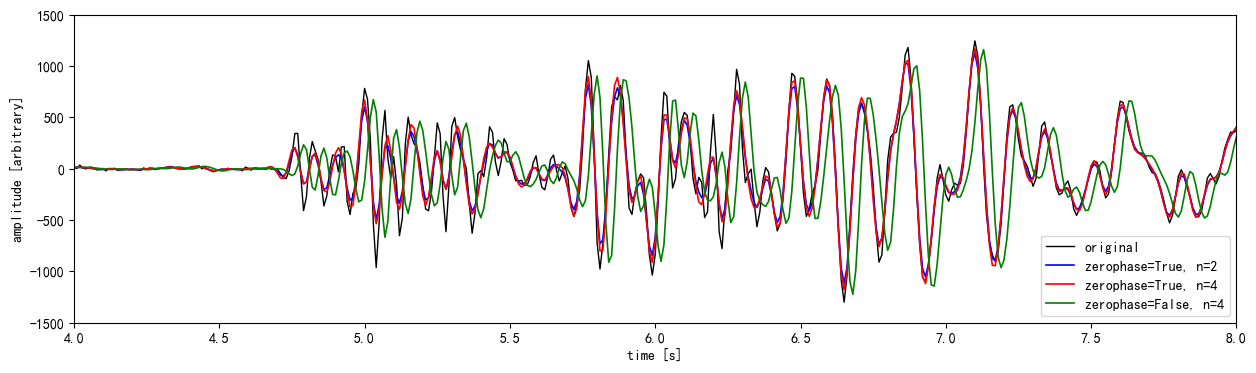

In [4]:
st = read('../data/filter_test_0.mseed')       
tr = st[0]                    
tr.detrend('demean')           
tr.detrend('linear')
tr.filter("highpass", freq=2)  # 移除长周期信号
print(tr)
t = tr.times()                 

f = 15.0                       # 滤波频率
start = 4                      # 开始时间
end = 8                        # 结束时间
amp = 1500                     # 振幅范围
ncorners = 4                   # 阶数

tr_filt1 = tr.copy() 
# 因果滤波器/零相位，阶数为2。           
tr_filt1.filter('lowpass', freq=f, zerophase=True, corners=ncorners/2)

tr_filt2 = tr.copy()   
# 因果滤波器/零相位，阶数为ncorners        
tr_filt2.filter('lowpass', freq=f, zerophase=True, corners=ncorners)

tr_filt3 = tr.copy() 
# 因果滤波器/非零相位，阶数为ncorners          
tr_filt3.filter('lowpass', freq=f, zerophase=False, corners=ncorners)

# 绘图
plt.rcParams['figure.figsize'] = 15, 4
plt.plot(t, tr.data, 'k', label='original', linewidth=1.)
plt.plot(t, tr_filt1.data, 'b', label='zerophase=True, n=2', linewidth=1.2)
plt.plot(t, tr_filt2.data, 'r', label='zerophase=True, n=%s' % ncorners, linewidth=1.2)
plt.plot(t, tr_filt3.data, 'g', label='zerophase=False, n=%s' % ncorners, linewidth=1.2)

plt.xlabel('time [s]')
plt.xlim(start, end)    
plt.ylim(-amp, amp)
plt.ylabel('amplitude [arbitrary]')
plt.legend(loc='lower right')

plt.show()

### 4.带通滤波
```
在不同的频率带中，会看到不同的特征。每个频率带都突出显示了不同频率范围内的信号成分。较低的频率带可能显示出长周期的振动，而较高的频率带可能显示出更短周期的振动。这可以帮助我们分析信号的频率内容并识别出不同的地震事件特征。
```

/home/muly/.local/lib/python3.11/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (10.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


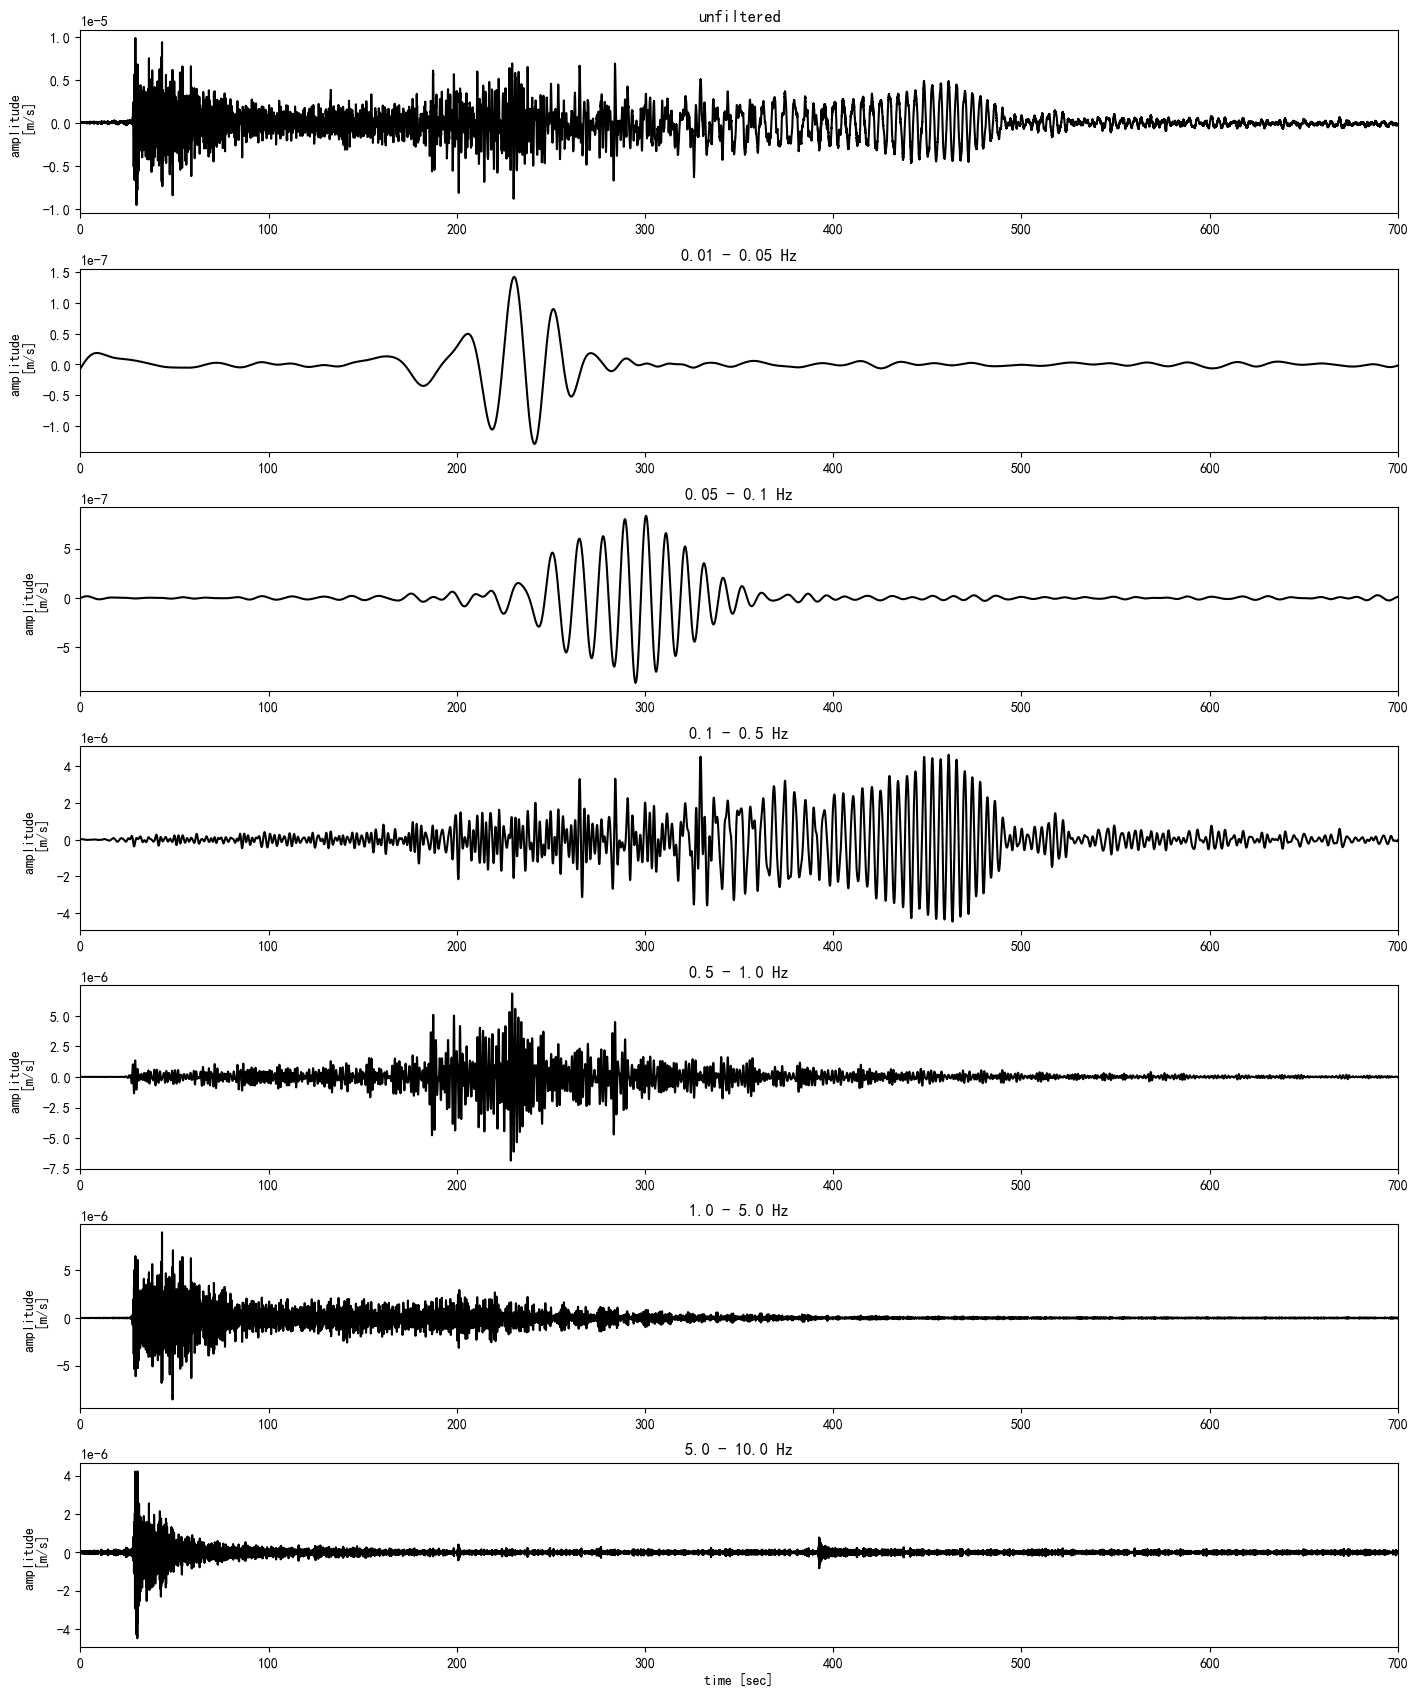

In [5]:
tr = read("../data/filter_test_1.mseed")[0]
tm = tr.times()
xmin = 0
xmax = 700

dat1 = tr.copy()
dat2 = tr.copy()
dat2.filter(type="bandpass", freqmin=0.01, freqmax=0.05, zerophase=True)
dat3 = tr.copy()
dat3.filter(type="bandpass", freqmin=0.05, freqmax=0.1, zerophase=True)
dat4 = tr.copy()
dat4.filter(type="bandpass", freqmin=0.1, freqmax=0.5, zerophase=True)
dat5 = tr.copy()
dat5.filter(type="bandpass", freqmin=0.5, freqmax=1, zerophase=True)
dat6 = tr.copy()
dat6.filter(type="bandpass", freqmin=1., freqmax=5., zerophase=True)
dat7 = tr.copy()
dat7.filter(type="bandpass", freqmin=5., freqmax=10., zerophase=True)

# 绘图
plt.rcParams['figure.figsize'] = 17, 21
fig = plt.figure()
ax1 = fig.add_subplot(7,1,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat1.data, 'k')
plt.xlim(xmin, xmax)
plt.title('unfiltered')
plt.ylabel('amplitude \n [m/s]')
ax2 = fig.add_subplot(7,1,2)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat2.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.01 - 0.05 Hz')
plt.ylabel('amplitude \n [m/s]')
ax3 = fig.add_subplot(7,1,3)
ax3.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat3.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.05 - 0.1 Hz')
plt.ylabel('amplitude \n [m/s]')
ax4 = fig.add_subplot(7,1,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat4.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.1 - 0.5 Hz')
plt.ylabel('amplitude \n [m/s]')
ax5 = fig.add_subplot(7,1,5)
ax5.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat5.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.5 - 1.0 Hz')
plt.ylabel('amplitude \n [m/s]')
ax6 = fig.add_subplot(7,1,6)
ax6.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat6.data, 'k')
plt.xlim(xmin, xmax)
plt.title('1.0 - 5.0 Hz')
plt.ylabel('amplitude \n [m/s]')
ax7 = fig.add_subplot(7,1,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat7.data, 'k')
plt.xlim(xmin, xmax)
plt.title('5.0 - 10.0 Hz')
plt.xlabel('time [sec]')
plt.ylabel('amplitude \n [m/s]')
plt.subplots_adjust(hspace=0.3)
plt.show()